<a href="https://colab.research.google.com/github/tikendraw/Amazon-review-sentiment-analysis/blob/main/amazon-review-sentiment-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Reviews for Sentiment Analysis

## Objective

Here we will be Building ML and DL models to predict the Polarity of reviews.
We will be performing series of experiments with different models to achieve the best classification metrics.(while not abusing the machine we have)

## About Dataset 
[Dataset here](https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews)


### OVERVIEW
Contains 34,686,770 Amazon reviews from 6,643,669 users on 2,441,053 products, from the Stanford Network Analysis Project (SNAP). This subset contains 1,800,000 training samples and 200,000 testing samples in each polarity sentiment.

### ORIGIN
The Amazon reviews dataset consists of reviews from amazon. The data span a period of 18 years, including ~35 million reviews up to March 2013. Reviews include product and user information, ratings, and a plaintext review. For more information, please refer to the following paper: J. McAuley and J. Leskovec. Hidden factors and hidden topics: understanding rating dimensions with review text. RecSys, 2013.

### DESCRIPTION
The Amazon reviews polarity dataset is constructed by taking review score 1 and 2 as negative, and 4 and 5 as positive. Samples of score 3 is ignored. In the dataset, class 1 is the negative and class 2 is the positive. Each class has 1,800,000 training samples and 200,000 testing samples.

If you need help extracting the train.csv and test.csv files check out the starter code.

The files train.csv and test.csv contain all the training samples as comma-separated values.

The CSVs contain polarity, title, text. These 3 columns in them, correspond to class index (1 or 2), review title and review text.

polarity - 1 for negative and 2 for positive
title - review heading
text - review body
The review title and text are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

In [1]:
# ! git clone https://github.com/tikendraw/funcyou.git -q
# ! pip install funcyou/
# ! rm -rf funcyou
# ! pip install tensorflow_hub

In [2]:
import numpy as np
import datetime
import tensorflow as tf
from tensorflow import keras
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.layers import Embedding ,LSTM, Dense, Dropout, Conv1D, MaxPool1D, BatchNormalization, TextVectorization
import matplotlib.pyplot as plt
import polars as pl
import tensorflow_hub as hub
import os, re, json
import tensorflow as tf
#preprocessing functions to clear punctuations, lower strings, remove special chars removing contractions
from funcyou.preprocessing.text import  text_cleaning_apos, cont_to_exp, text_cleaning
from util import IntegerVectorizer
import sys
import pandas as pd
from pathlib import Path
import pickle
import tarfile
# importing useful functions
from funcyou.sklearn.metrics import calculate_results
from funcyou.plot import plot_history, compare_histories

print('Tf version: ',tf.__version__)
print('GPU: ',len(tf.config.list_physical_devices('GPU')))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["TFHUB_CACHE_DIR"] = './tmp/tfhub'


use_url = 'https://storage.googleapis.com/tfhub-modules/google/universal-sentence-encoder/4.tar.gz'


2023-08-23 20:53:59.708669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 20:54:00.825229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tf version:  2.12.1
GPU:  0


2023-08-23 20:54:05.509406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 20:54:05.694017: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
data_dir = Path(os.getcwd()).parent /'dataset'
data_dir

PosixPath('/home/t/aproject/Amazon-review-sentiment-analysis/dataset')

In [4]:
def download_USEncoder():

    try:
        print('downloading universal sentence encoder...')
        use_filename = wget.download(use_url)

        print('Downloaded!')
        # Extracting
        os.makedirs('universal_sentence_encoder', exist_ok = True)
        print('Extracting universal sentence encoder....')
        # open file
        file = tarfile.open(use_filename)
        
        # extracting file
        file.extractall('./universal_sentence_encoder')
        
        file.close()
        print('Extracted.')
    except Exception as e:
        print(e)


In [5]:
# Download the data if you don't have locally
data_url = 'https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews'

def download_data(data_url):
    download_kaggle_dataset(url = data_url)
    print('Dataset Downloaded.')

    import zipfile
    with zipfile.ZipFile('./amazon-reviews.zip', 'r') as zip_ref:
        zip_ref.extractall('./dataset')
    print('Extracted.')




In [6]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    download_USEncoder()
    download = input('Did you upload kaggle.json?(Yes/No) ')
    if download in ['yes','Yes','Y','y']:
        print('Dataset Downloading...')
        download_data(data_url)
    
else:
  print('Not running on CoLab')


Not running on CoLab


In [7]:
# embed = hub.KerasLayer("../universal_sentence_encoder")

# Load the data

In [5]:
#reading data
df = pl.read_csv(data_dir/'train.csv',new_columns = ['polarity', 'title','text'])  # gives TextFileReader, which is iterable with chunks of 1000 rows.


In [6]:
df.describe()

describe,polarity,title,text
str,f64,str,str
"""count""",3.599999e6,"""3599999""","""3599999"""
"""null_count""",0.0,"""0""","""0"""
"""mean""",1.5,null,null
"""std""",0.5,null,null
"""min""",1.0,"""""","""this is the b…"
"""max""",2.0,"""♦ LOVE IT ♦""","""…were Marvin a…"
"""median""",1.0,null,null
"""25%""",1.0,null,null
"""75%""",2.0,null,null


In [7]:
df.columns

['polarity', 'title', 'text']

In [8]:
print('Shape: ', df.shape)

Shape:  (3599999, 3)


In [9]:
# check for nulls and drop if any
df.null_count()

polarity,title,text
u32,u32,u32
0,0,0


In [10]:
#drop nulls
df.drop_nulls()
print()

In [11]:
# df.to_pandas().isna().sum()

In [12]:
# checking for classs imbalance
df['polarity'].value_counts()

polarity,counts
i64,u32
1,1800000
2,1799999


**Note:** The dataset is fairly large, we will use tensorflow's data api to load and handle the data

# We will map the polarity between 0 for negative sentiment to 1 for positive sentiment

In [13]:
df = df.with_columns([
                    pl.col('polarity').apply(lambda x: 0 if x == 1 else 1).alias('polarity')
                     ])

df = df.with_columns([
                     pl.col('polarity').cast(pl.Int16, strict=False).alias('polarity')
                     ])


In [14]:
df.sample(10)

polarity,title,text
i16,str,str
0,"""Please don't r…","""Please don't r…"
1,"""kayaker""","""I really like …"
0,"""Awful.......""","""A horrendous w…"
1,"""Brought for gr…","""The figure was…"
1,"""FANTASTIC CUST…","""had a bit of m…"
0,"""buy another ve…","""This is a reco…"
0,"""Pretty but pra…","""I was bowled o…"
1,"""Gods and Gener…","""Excellent movi…"
0,"""Bad audio expe…","""I ordered this…"


## Note: We will be combining text and title columns . makes more sense.

In [22]:
import seaborn as sns
from funcyou.plot import distplot_axis

In [25]:
%%time

pattern = r'\b\w+\b'


df = df.with_columns([
    (pl.col('title')+' ' + pl.col('text')).alias('review')
])


CPU times: user 584 ms, sys: 887 ms, total: 1.47 s
Wall time: 6.78 s


In [17]:
df = df.select(['review','polarity'])

In [18]:
def clean_text(x: str) -> str:
    x = re.sub(r'[^\w\s]', '', x)  # Remove punctuation
    x = x.lower()  # Convert to lowercase
    return x    

In [26]:
df = df.with_columns([
    pl.col('title').apply(lambda x: len(str(x).split())).alias('title_len'),
    pl.col('text').apply(lambda x: len(str(x).split())).alias('text_len'),
    pl.col('review').apply(lambda x: len(str(x).split())).alias('review_len')
])


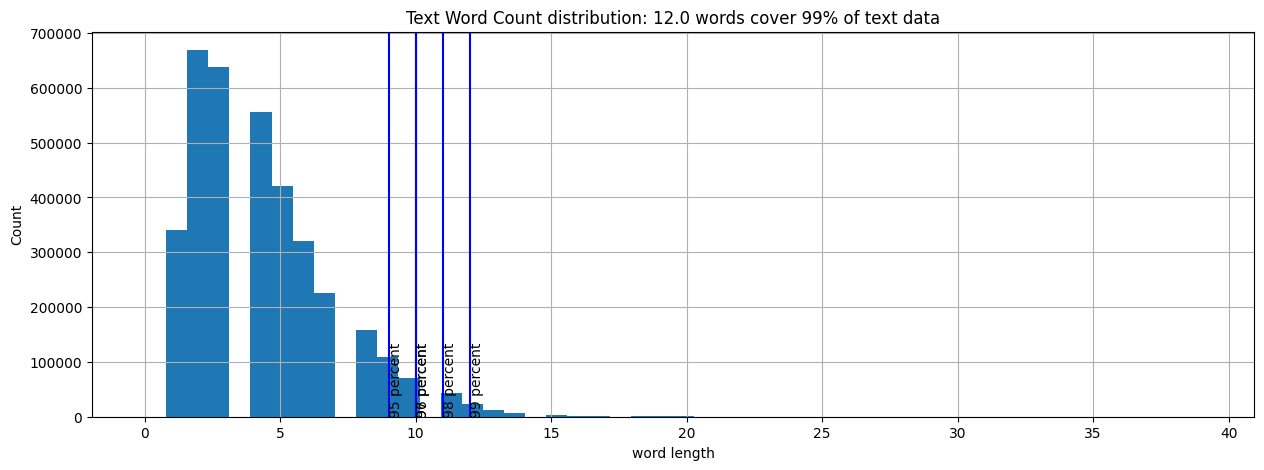

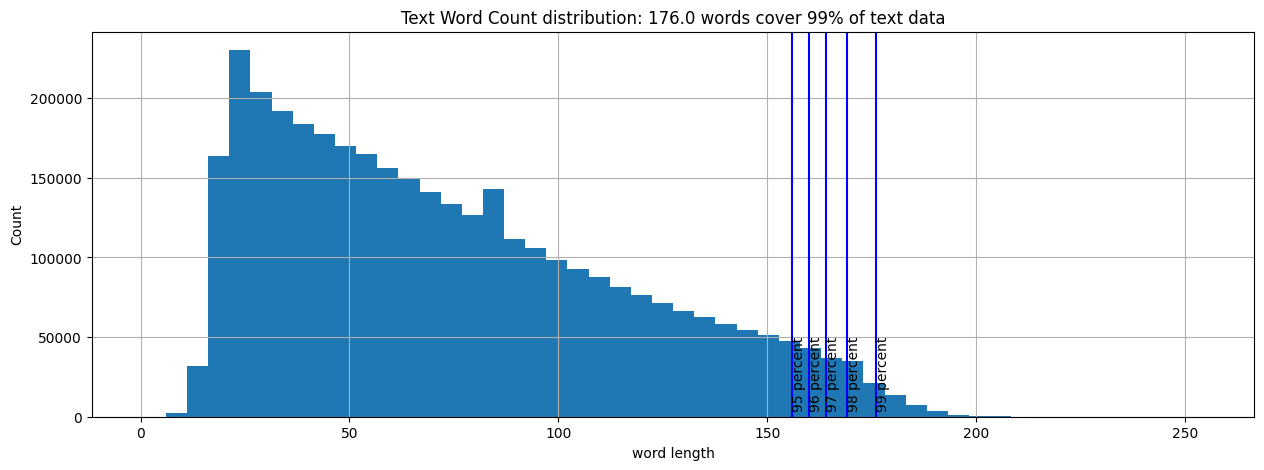

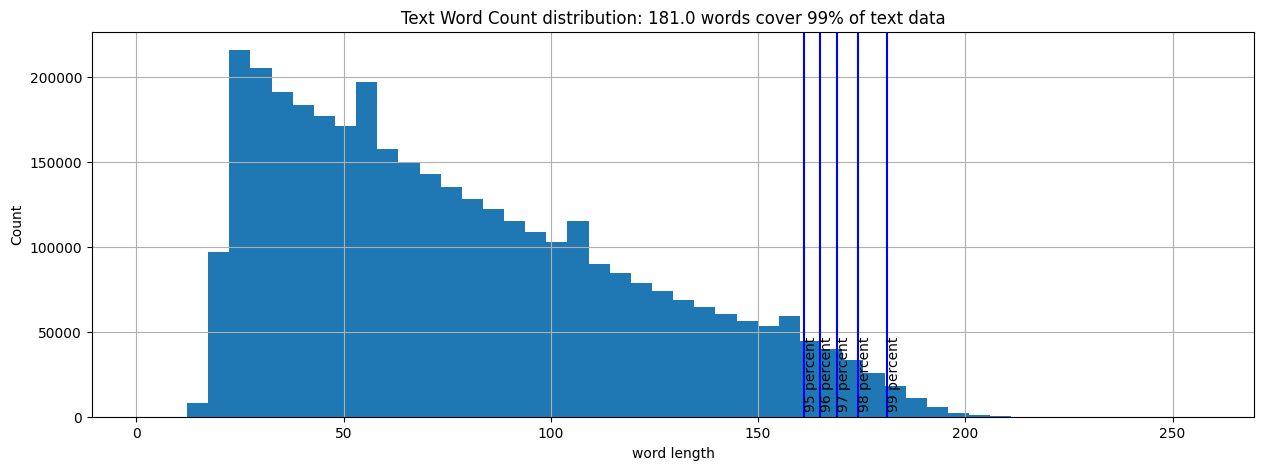

In [27]:

plt.figure(figsize=(15,5))
distplot_axis(df['title_len'].to_numpy())

plt.figure(figsize=(15,5))
distplot_axis(df['text_len'].to_numpy())

plt.figure(figsize=(15,5))
distplot_axis(df['review_len'].to_numpy())

In [23]:
# dff = df.select(['review', 'polarity'])

In [24]:
# dff.head()

In [25]:
# dff.write_csv(data_dir / 'preprocessed_df.csv')

In [26]:

def sizeof_fmt(num, suffix="B"):
    """by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified"""
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, "Yi", suffix)
    

for name, size in sorted(
    ((name, sys.getsizeof(value)) for name, value in locals().items()),
    key=lambda x: -x[1],
)[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                 MultinomialNB:  1.6 KiB
               TfidfVectorizer:  1.6 KiB
                      Pipeline:  1.6 KiB
                     Embedding:  1.6 KiB
                          LSTM:  1.6 KiB
                         Dense:  1.6 KiB
                       Dropout:  1.6 KiB
                        Conv1D:  1.6 KiB
                     MaxPool1D:  1.6 KiB
            BatchNormalization:  1.6 KiB


In [4]:
df = pl.read_csv(data_dir/'preprocessed_df.csv')
df.head()

review,polarity
str,i64
"""the best sound…",1
"""amazing this s…",1
"""excellent soun…",1
"""remember pull …",1
"""an absolute ma…",1


A dataframe to store results

In [28]:
#creating a dataframe to store results
all_result = pd.DataFrame(columns=['model','accuracy','precision','recall','f1','discription'])

In [29]:
def add_to_big_result(res:dict):
    global all_result
    res = pd.DataFrame([res])
    all_result = pd.concat([all_result, res], ignore_index=True)
    print(all_result)
    return all_result

# Data Preparation

In [30]:
xtrain, xtest, ytrain, ytest = train_test_split( df.select('review'), df.select('polarity'),train_size=0.1, test_size=  .001,  random_state = 89)
# xtrain, xval, ytrain, yval = train_test_split( xtrain, ytrain, test_size=  .05, random_state = 89)

print('xtrain shape',xtrain.shape, 'ytrain shape', ytrain.shape)
print('xtest shape',xtest.shape, 'ytest shape', ytest.shape)
# print('xval shape',xval.shape, 'yval shape', yval.shape)

xtrain shape (359999, 1) ytrain shape (359999, 1)
xtest shape (3600, 1) ytest shape (3600, 1)


In [31]:
del(df) # deleting variables to keep the memory free

# Creating tensorflow dataset using `tf.data` api

In [32]:
#train
train_feature = tf.data.Dataset.from_tensor_slices(xtrain.to_numpy())
train_label = tf.data.Dataset.from_tensor_slices(ytrain.to_numpy())
#test
test_feature = tf.data.Dataset.from_tensor_slices(xtest.to_numpy())
test_label = tf.data.Dataset.from_tensor_slices(ytest.to_numpy())

BATCH_SIZE = 64

# Text vectorization

In [33]:
MAX_TOKEN = 100_000
OUTPUT_SEQUENCE_LENGTH = 100  # limiting reviews to 200 words

In [34]:
text_vectorizer = TextVectorization(max_tokens=MAX_TOKEN, standardize='lower_and_strip_punctuation',
                                   split='whitespace',
                                    ngrams= None ,
                                    output_mode='int',
                                    output_sequence_length=OUTPUT_SEQUENCE_LENGTH, 
                                    pad_to_max_tokens=False)

In [35]:
random_review = 'WHo the duck are you?'

In [36]:
# Later unpickle and use 
# `config` to create object and 
# `weights` to load the trained weights. 
text_vector_filename = 'tv_layer.pkl'

from_disk = pickle.load(open(text_vector_filename, "rb"))
text_vectorizer = TextVectorization.from_config(from_disk['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
text_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
text_vectorizer.set_weights(from_disk['weights'])

# Lets see the Vector for word "this"
print (text_vectorizer(random_review))

2023-08-23 13:49:25.914299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


tf.Tensor(
[  73    2 6016   26   14    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int64)


In [37]:
print('random Review: ', random_review)
print('random Review length: ', len(random_review))
print('-------\n')
print('vectorized review: ',text_vectorizer(random_review))
print('-------\n')
print('Vocabulary_length: ',len(text_vectorizer.get_vocabulary()))
print('Most frequent words: ',text_vectorizer.get_vocabulary()[:10])
print('least frequent words: ',text_vectorizer.get_vocabulary()[-10:])

random Review:  WHo the duck are you?
random Review length:  21
-------

vectorized review:  tf.Tensor(
[  73    2 6016   26   14    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int64)
-------

Vocabulary_length:  10000
Most frequent words:  ['', '[UNK]', 'the', 'i', 'and', 'a', 'to', 'it', 'of', 'this']
least frequent words:  ['relied', 'crust', 'tummy', 'toll', 'sly', 'morbid', 'marty', 'aforementioned', 'refresher', 'bedding']


In [38]:
train_dataset = tf.data.Dataset.zip((train_feature, train_label))
train_dataset = train_dataset.map(lambda x,y: (text_vectorizer(x)[0],y),tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.zip((test_feature, test_label))
test_dataset = test_dataset.map(lambda x,y: (text_vectorizer(x)[0],y),tf.data.AUTOTUNE )
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [39]:
print('len train dataset: ', len(train_dataset))
print('len test dataset: ', len(test_dataset))
# print('len val dataset: ', len(val_dataset))

len train dataset:  5625
len test dataset:  57


In [40]:
for i, j in train_dataset.take(1):
    print(i.shape, j.shape)
    # print(i)
    # print(j)
    break

(64, 100) (64, 1)


2023-08-23 13:49:27.242069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [359999,1]
	 [[{{node Placeholder/_0}}]]
2023-08-23 13:49:27.242621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [359999,1]
	 [[{{node Placeholder/_2}}]]


In [41]:
del(train_feature, train_label, test_feature, test_label) # deleting variables to keep the memory free

In [42]:
# Pickle the config and weights
pickle.dump({'config': text_vectorizer.get_config(),
             'weights': text_vectorizer.get_weights()}
            , open(text_vector_filename, "wb"))



# Embedding

In [43]:
DIM = 8

In [44]:
embedding = Embedding(input_dim = MAX_TOKEN,output_dim= DIM, mask_zero=True, input_length=OUTPUT_SEQUENCE_LENGTH)
print('Embedded text vectorized random sentence: ',embedding(text_vectorizer(random_review)))

Embedded text vectorized random sentence:  tf.Tensor(
[[ 0.01116733 -0.00401229 -0.03286948 -0.04219323 -0.03392152  0.02585584
   0.04046727 -0.0370817 ]
 [ 0.00542203  0.04730327  0.03418661 -0.01838063 -0.04171194  0.01430145
   0.04881308 -0.046259  ]
 [ 0.02219654 -0.01794132  0.0236889   0.04808782  0.03102423 -0.04773659
  -0.01252197 -0.00990858]
 [-0.0204428  -0.04757566 -0.02221361  0.03512459  0.02598567 -0.03920225
   0.03544864 -0.04027382]
 [-0.04117963  0.02249651 -0.04621316 -0.04888072 -0.04970881  0.01216479
   0.02384043 -0.01833731]
 [ 0.04203096 -0.007996   -0.0113402  -0.01959705 -0.01620471 -0.0338641
  -0.01640882  0.04877475]
 [ 0.04203096 -0.007996   -0.0113402  -0.01959705 -0.01620471 -0.0338641
  -0.01640882  0.04877475]
 [ 0.04203096 -0.007996   -0.0113402  -0.01959705 -0.01620471 -0.0338641
  -0.01640882  0.04877475]
 [ 0.04203096 -0.007996   -0.0113402  -0.01959705 -0.01620471 -0.0338641
  -0.01640882  0.04877475]
 [ 0.04203096 -0.007996   -0.0113402  -0.

# Model:0 (Naive bayes model)

In [45]:
model0 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('multino',MultinomialNB())
])

In [46]:
%%time
#fit and predict
model0.fit(xtrain['review'], ytrain)

CPU times: user 16.9 s, sys: 509 ms, total: 17.4 s
Wall time: 22.1 s


/home/t/miniconda3/envs/deep/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('multino', MultinomialNB())])

In [47]:
pred0 = model0.predict(xtest['review'])

print(pred0.shape ==  ytest.shape)
print('pred00.shape: ',pred0.shape)
print('ytest.shape: ',ytest.shape)

model0_res = calculate_results(y_true=ytest, y_pred=pred0, model_name='model0: naive bayes')
print(model0_res)

False
pred00.shape:  (3600,)
ytest.shape:  (3600, 1)
{'model': 'model0: naive bayes', 'accuracy': 84.44444444444444, 'precision': 0.8445210957221939, 'recall': 0.8444444444444444, 'f1': 0.8444316721022861, 'discription': None}


In [48]:
# preditions on texts is more accurate than titles, simply because there is more words and combinations which describes the sentiments better.

In [49]:
all_result =add_to_big_result(model0_res)

                 model   accuracy  precision    recall        f1 discription
0  model0: naive bayes  84.444444   0.844521  0.844444  0.844432        None


# Model1

In [117]:
inputs  = keras.Input(shape= (100))
# vectorizer_layer  = text_vectorizer(inputs)
embedding_layer  = embedding(inputs)

x = LSTM(16, return_sequences=True)(embedding_layer)
x = LSTM(16)(x)
x = Dropout(.4)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)

#building model
model1 = keras.Model(inputs = inputs, outputs = outputs, name = 'model1_lstm')

#compiling model
model1.compile(loss = keras.losses.binary_crossentropy,
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [62]:
EPOCHS = 10
# print(len(train_dataset), len(val_dataset))

In [52]:
model_dir = Path(os.getcwd()).parent /'model'
model_dir

PosixPath('/home/t/aproject/Amazon-review-sentiment-analysis/model')

In [54]:
model1 = tf.keras.models.load_model(model_dir/'model1.h5')

In [69]:
# %%time

# fit the model
history1 = model1.fit(train_dataset, epochs = EPOCHS, 
                      validation_data= test_dataset, 
                      # steps_per_epoch=int(0.1*(len(train_dataset) / EPOCHS)),
                      validation_steps=int(1*(len(test_dataset) / EPOCHS))
                    )

Epoch 1/10


56/56 [==============================] - 25s 175ms/step - loss: 0.5720 - accuracy: 0.7751 - val_loss: 0.3434 - val_accuracy: 0.8875
Epoch 2/10
56/56 [==============================] - 6s 110ms/step - loss: 0.2668 - accuracy: 0.9085 - val_loss: 0.3221 - val_accuracy: 0.8813
Epoch 3/10
56/56 [==============================] - 6s 101ms/step - loss: 0.3195 - accuracy: 0.8789 - val_loss: 0.2919 - val_accuracy: 0.8875
Epoch 4/10
56/56 [==============================] - 6s 100ms/step - loss: 0.2894 - accuracy: 0.8915 - val_loss: 0.3191 - val_accuracy: 0.8719
Epoch 5/10
56/56 [==============================] - 6s 100ms/step - loss: 0.2726 - accuracy: 0.9004 - val_loss: 0.2957 - val_accuracy: 0.8719
Epoch 6/10
56/56 [==============================] - 6s 102ms/step - loss: 0.2832 - accuracy: 0.8912 - val_loss: 0.3087 - val_accuracy: 0.8781
Epoch 7/10
56/56 [==============================] - 6s 101ms/step - loss: 0.2996 - accuracy: 0.8898 - val_loss: 0.2931 - val_accuracy: 0.8781
Epoch 8/10
56/56

In [ ]:
# model1.save(model_dir/'model1.h5')

In [56]:
from funcyou.plot import plot_history

In [70]:
h1 = pd.DataFrame(history1.history)
h1

,loss,accuracy,val_loss,val_accuracy
0,0.572030,0.775112,0.343423,0.887500
1,0.266768,0.908482,0.322056,0.881250
2,0.319549,0.878906,0.291871,0.887500
3,0.289393,0.891462,0.319051,0.871875
4,0.272560,0.900391,0.295719,0.871875
5,0.283191,0.891183,0.308671,0.878125
6,0.299627,0.889788,0.293057,0.878125
7,0.263328,0.905692,0.299051,0.868750
8,0.280136,0.895926,0.290154,0.887500
9,0.296478,0.886998,0.285403,0.887500


In [107]:
from funcyou.plot import plot_history

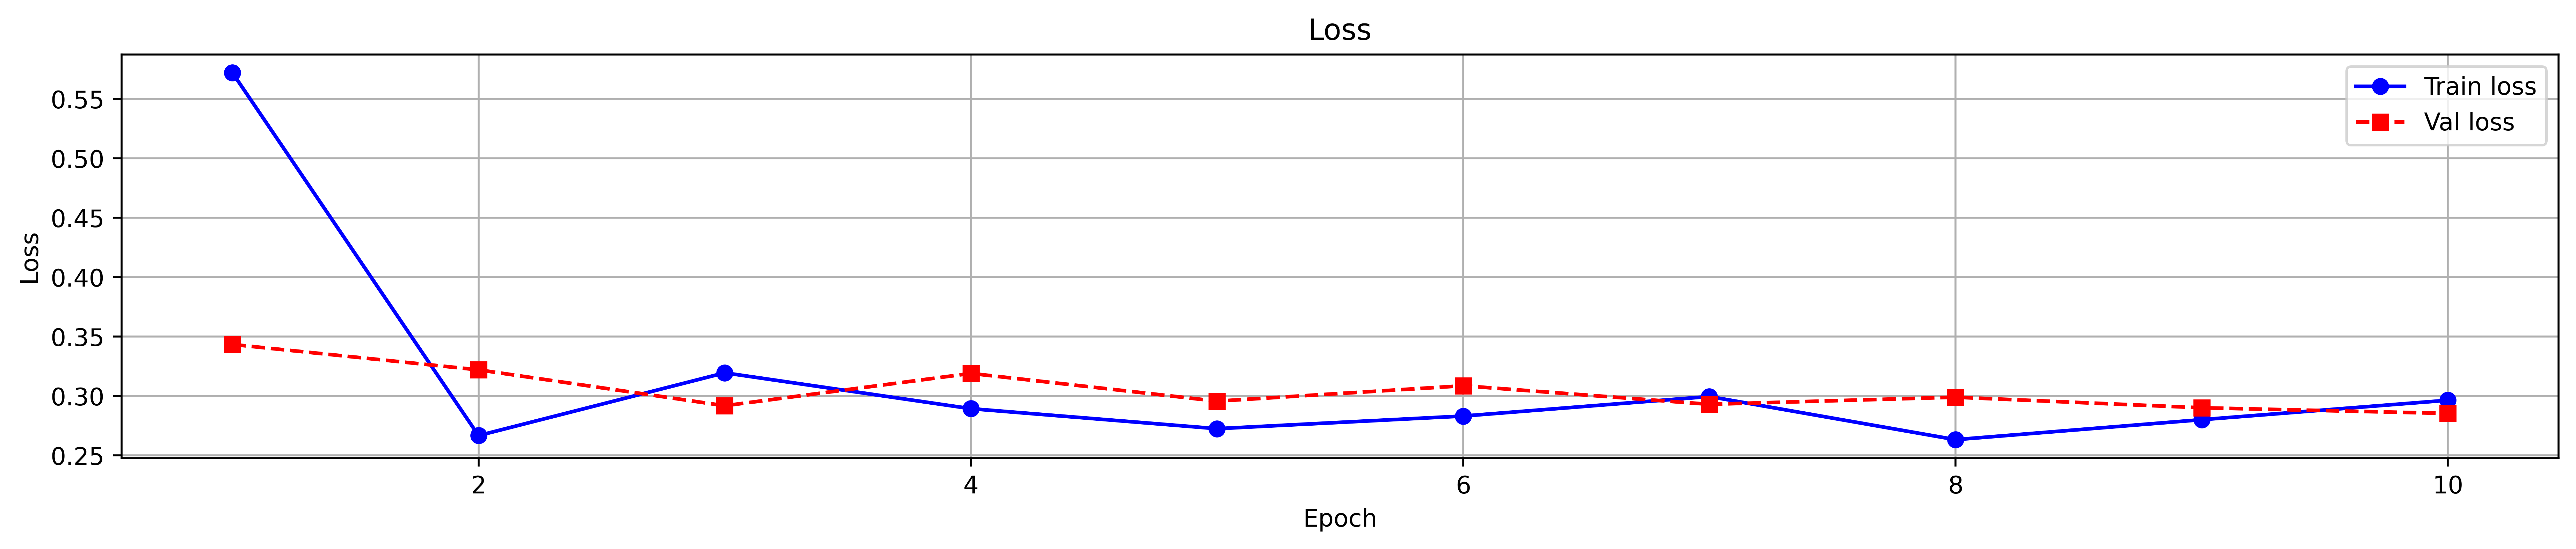

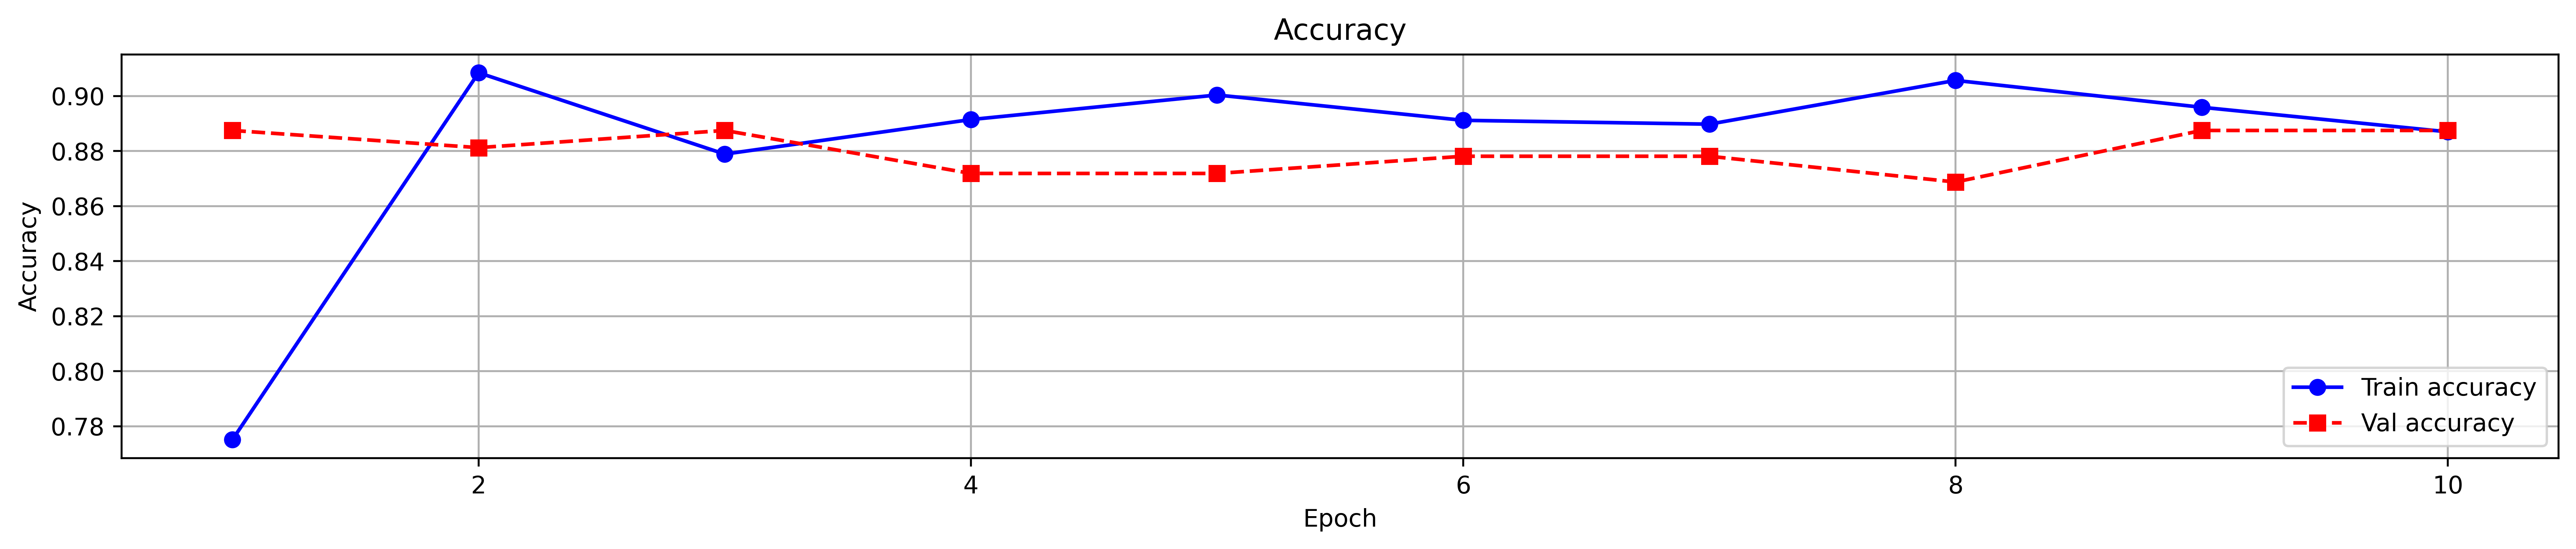

In [108]:
#plot history
# plot_history(history1, plot=['loss','accuracy'], figsize=(15,5))
plot_training_history(history1, metrics=['loss', 'accuracy'], figsize=(18,3))


#### Evaluation

In [111]:
ypred1 = tf.squeeze(tf.round(model1.predict(test_dataset)))
print('ypred1.shape: ',ypred1.shape)

model1_res = calculate_results(ytest,ypred1, model_name='model1: LSTM', discription = 'small lstm model with vectorizer and embedding layer')
print(model1_res)

# adding result to all_result 
all_result = add_to_big_result(model1_res)

57/57 [==============================] - 6s 22ms/step
ypred1.shape:  (3600,)
{'model': 'model1: LSTM', 'accuracy': 87.19444444444444, 'precision': 0.8719821383883883, 'recall': 0.8719444444444444, 'f1': 0.8719389997538507, 'discription': 'small lstm model with vectorizer and embedding layer'}
                 model   accuracy  precision    recall        f1  \
0  model0: naive bayes  84.444444   0.844521  0.844444  0.844432   
1         model1: LSTM  87.194444   0.871982  0.871944  0.871939   

                                         discription  
0                                               None  
1  small lstm model with vectorizer and embedding...  


In [112]:
all_result

,model,accuracy,precision,recall,f1,discription
0,model0: naive bayes,84.444444,0.844521,0.844444,0.844432,None
1,model1: LSTM,87.194444,0.871982,0.871944,0.871939,small lstm model with vectorizer and embedding...
